# 모듈 Import

In [68]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기

In [69]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [70]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 데이터 탐색

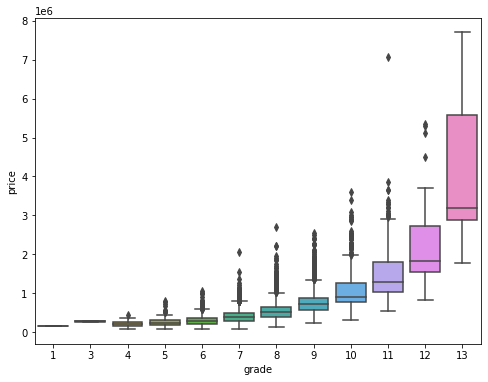

In [71]:
# 집의 등급에 따른 가격
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

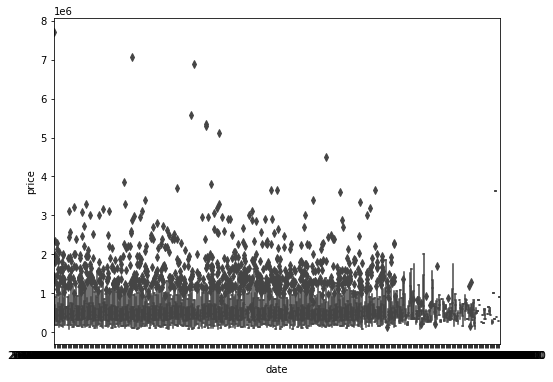

In [72]:
# 집을 구매한 날짜에 따른 가격
data = pd.concat([train['price'], train['date']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='date', y="price", data=data)

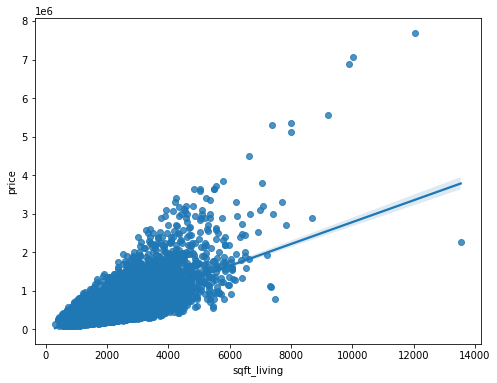

In [73]:
# 거실 크기에 따른 가격
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

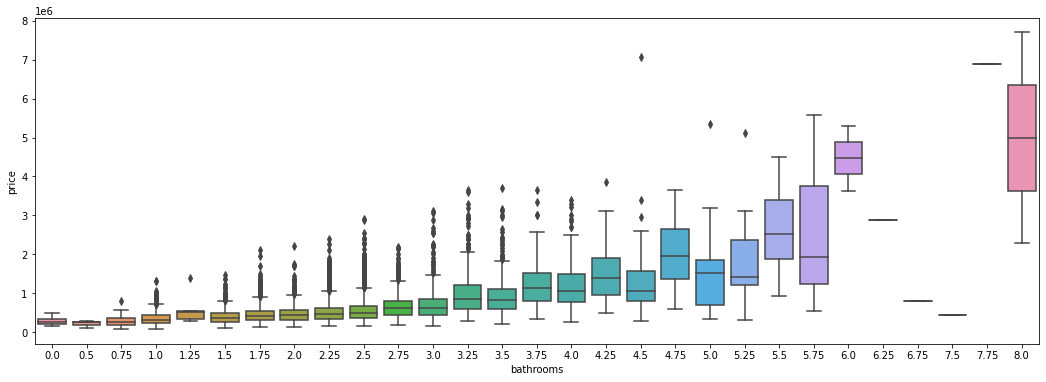

In [74]:
# 욕실 수에 따른 가격
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

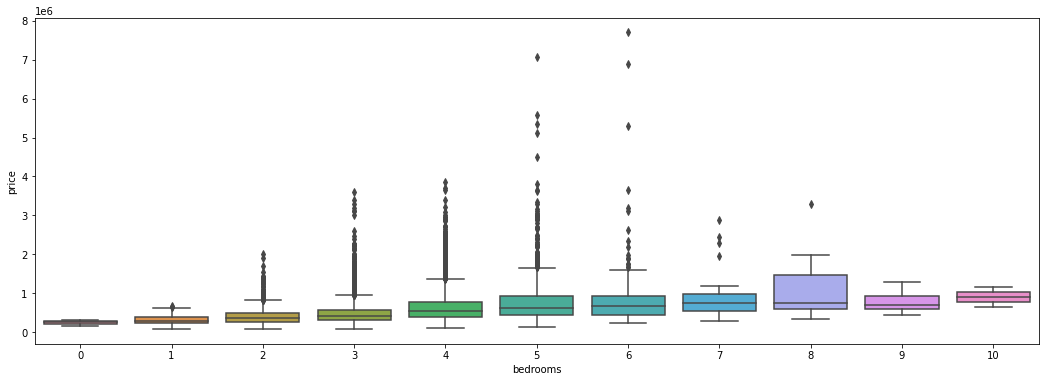

In [75]:
# 침실 수에 따른 가격
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

# 전처리

In [77]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [78]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [79]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [80]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [81]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

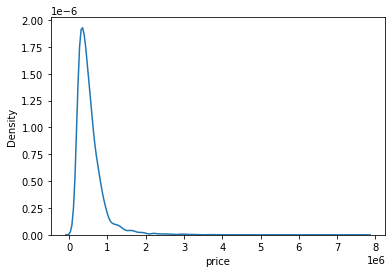

In [82]:
sns.kdeplot(y)
plt.show()

In [83]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

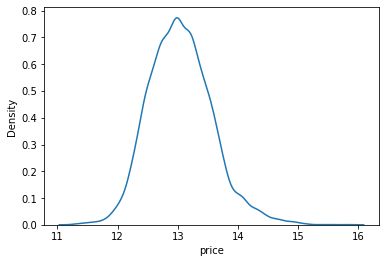

In [84]:
sns.kdeplot(y)
plt.show()

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 모델 튜닝

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [87]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [88]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [89]:
random_state=2022 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [90]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 130361.23368538941,
 'XGBRegressor': 127865.51864932069,
 'LGBMRegressor': 120099.06723661404,
 'RandomForestRegressor': 135139.59142571784}

In [91]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,135139.591426
GradientBoostingRegressor,130361.233685
XGBRegressor,127865.518649
LGBMRegressor,120099.067237


LGBMRegressor 가 RMSE가 가장 낮으므로 이 모델을 써서 그리드서치를 해본다

# 그리드 탐색

In [92]:
from sklearn.model_selection import GridSearchCV

In [93]:
model = LGBMRegressor(random_state=random_state)

In [94]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

1. GridSearchCV 모델로 model 초기화
2. 모델 fitting
3. params, score에 각 조합에 대한 결과를 저장
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 results 반환

In [95]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [97]:
param_grid = {
    'n_estimators': [100, 1000, 10000],
    'max_depth': [10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,max_depth,n_estimators,score,RMSLE
1,10,1000,-0.026739,0.163521
0,10,100,-0.027027,0.164399
2,10,10000,-0.027824,0.166805


100보다 1000이 더 낮으므로 n_estimators 하이퍼파라미터값으로 1000을 쓴다

In [98]:
param_grid = {
    'n_estimators': [1000],
    'max_depth': [10, 15, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,max_depth,n_estimators,score,RMSLE
0,10,1000,-0.026739,0.163521
2,20,1000,-0.026786,0.163663
1,15,1000,-0.026958,0.164190


In [99]:
param_grid = {
    'n_estimators': [1000],
    'max_depth': [5, 6, 7, 8, 9, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,1000,-0.026739,0.163521
2,7,1000,-0.026810,0.163736
1,6,1000,-0.026857,0.163882
0,5,1000,-0.026862,0.163896
4,9,1000,-0.026886,0.163968
3,8,1000,-0.026911,0.164045


에러율이 가장 낮은 max_depth = 10을 그대로 썼다

In [101]:
param_grid = {
    'num_leaves': [10, 20, 30, 40, 50],
    'min_child_samples': [26],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,min_child_samples,num_leaves,score,RMSLE
4,26,50,-0.026989,0.164283
3,26,40,-0.027071,0.164532
2,26,30,-0.027114,0.164665
1,26,20,-0.027764,0.166624
0,26,10,-0.030041,0.173323


In [102]:
param_grid = {
    'num_leaves': [50, 60, 70, 80, 90, 100],
    'min_child_samples': [26],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,min_child_samples,num_leaves,score,RMSLE
2,26,70,-0.026717,0.163453
1,26,60,-0.026761,0.163589
4,26,90,-0.026886,0.163969
3,26,80,-0.026898,0.164006
0,26,50,-0.026989,0.164283
5,26,100,-0.027054,0.164481


total leaves 는 70으로 하겠다

In [103]:
param_grid = {
    'num_leaves': [70],
    'min_child_samples': [10, 20, 30, 40, 50],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,min_child_samples,num_leaves,score,RMSLE
3,40,70,-0.026712,0.163437
4,50,70,-0.026873,0.163930
2,30,70,-0.026878,0.163946
0,10,70,-0.026880,0.163950
1,20,70,-0.026925,0.164088


min_child_samples는 40으로 하겠다

### 가장 좋은 조합의 하이퍼파라미터로 모델 예측하기

In [104]:
model = LGBMRegressor(max_depth=10, n_estimators=1000, num_leaves = 70, min_child_samples = 40, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12334159, 13.15388402, 14.03650916, ..., 13.08551605,
       12.63358322, 12.98585684])

In [105]:
#예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌린다
prediction = np.expm1(prediction)
prediction

array([ 500488.34320215,  516010.3394333 , 1247320.6896292 , ...,
        481910.63753635,  306686.07841427,  436199.30861663])

In [106]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [108]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.163437')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.163437.csv saved!
[CV] END ................min_child_samples=26, num_leaves=10; total time=   0.4s
[CV] END ................min_child_samples=26, num_leaves=20; total time=   0.5s
[CV] END ................min_child_samples=26, num_leaves=20; total time=   0.5s
[CV] END ................min_child_samples=26, num_leaves=30; total time=   0.8s
[CV] END ................min_child_samples=26, num_leaves=40; total time=   0.6s
[CV] END ................min_child_samples=26, num_leaves=50; total time=   0.7s
[CV] END ................min_child_samples=26, num_leaves=50; total time=   0.7s
[CV] END ................min_child_samples=26, num_leaves=60; total time=   0.8s
[CV] END ................min_child_samples=26, num_leaves=70; total time=   0.9s
[CV] END ................min_child_samples=26, num_leaves=80; total time=   1.2s
[CV] END ................min_child_samples=26, num_leaves=80; total time=   2.1s
[CV] END ...............min

In [109]:
# !pip install IPython 
from IPython.display import Image 

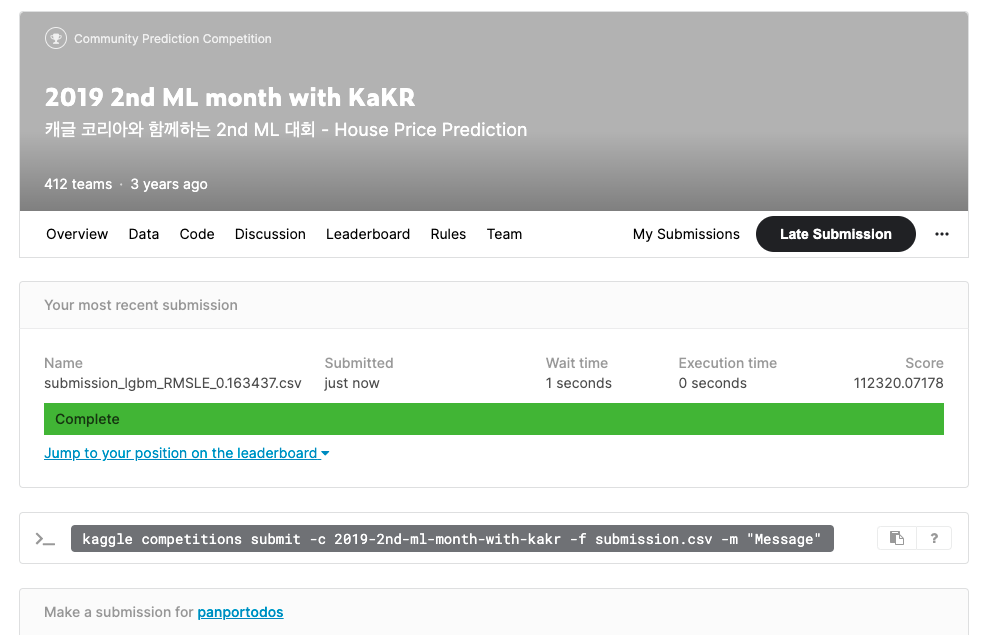

In [114]:
Image("kaggle_score.png")

In [ ]:
#